## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [98]:
import pandas as pd
import csv
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

df = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv', index_col=0)
df.head(5)



,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


### What are the variable types in the data?
All three variables are integers. An integer is a whole number such as 1, 100, or 5000. The int64 tells us that the number has to between -9223372036854775808 to 9223372036854775807. Unless you're working with some really big integers, int64 should capture all your data.

In [99]:
df.dtypes

age              int64
weight           int64
exercise_time    int64
dtype: object

### What are the relationships between the variables?

There is a relationship between age and weight and weight and exercise time.

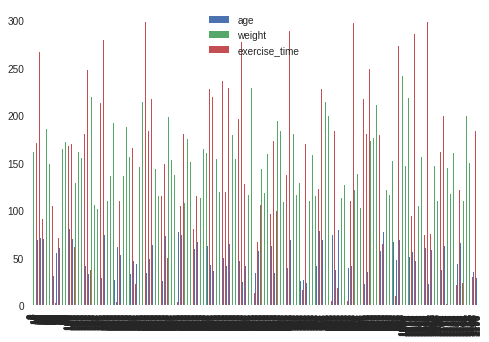

In [100]:
df.plot.bar()

In [101]:
from sklearn import preprocessing
import pandas as pd

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dfnormal = pd.DataFrame(x_scaled)
dfnormal.columns = ['age', 'weight', 'exercise_time']
dfnormal.head(5)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,age,weight,exercise_time
0,0.419355,0.123288,0.640000
1,0.370968,0.417808,0.116667
2,0.451613,0.191781,0.733333
3,0.338710,0.794521,0.190000
4,0.161290,0.109589,0.606667


Text(0.5,1,'Normalized Boxplots')

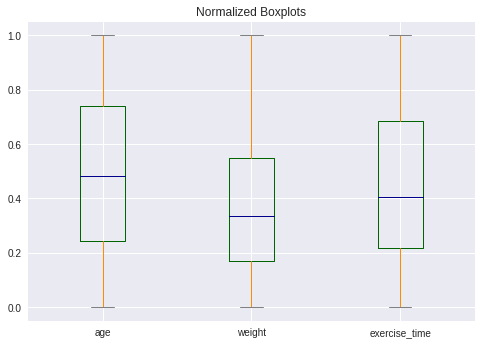

In [102]:
import seaborn as sns
color = dict(boxes='DarkGreen', whiskers='DarkOrange',medians='DarkBlue', caps='Gray')
sns.set_style("darkgrid")
dfnormal.plot.box(color=color, sym='r+', stacked=True).set_title('Normalized Boxplots')

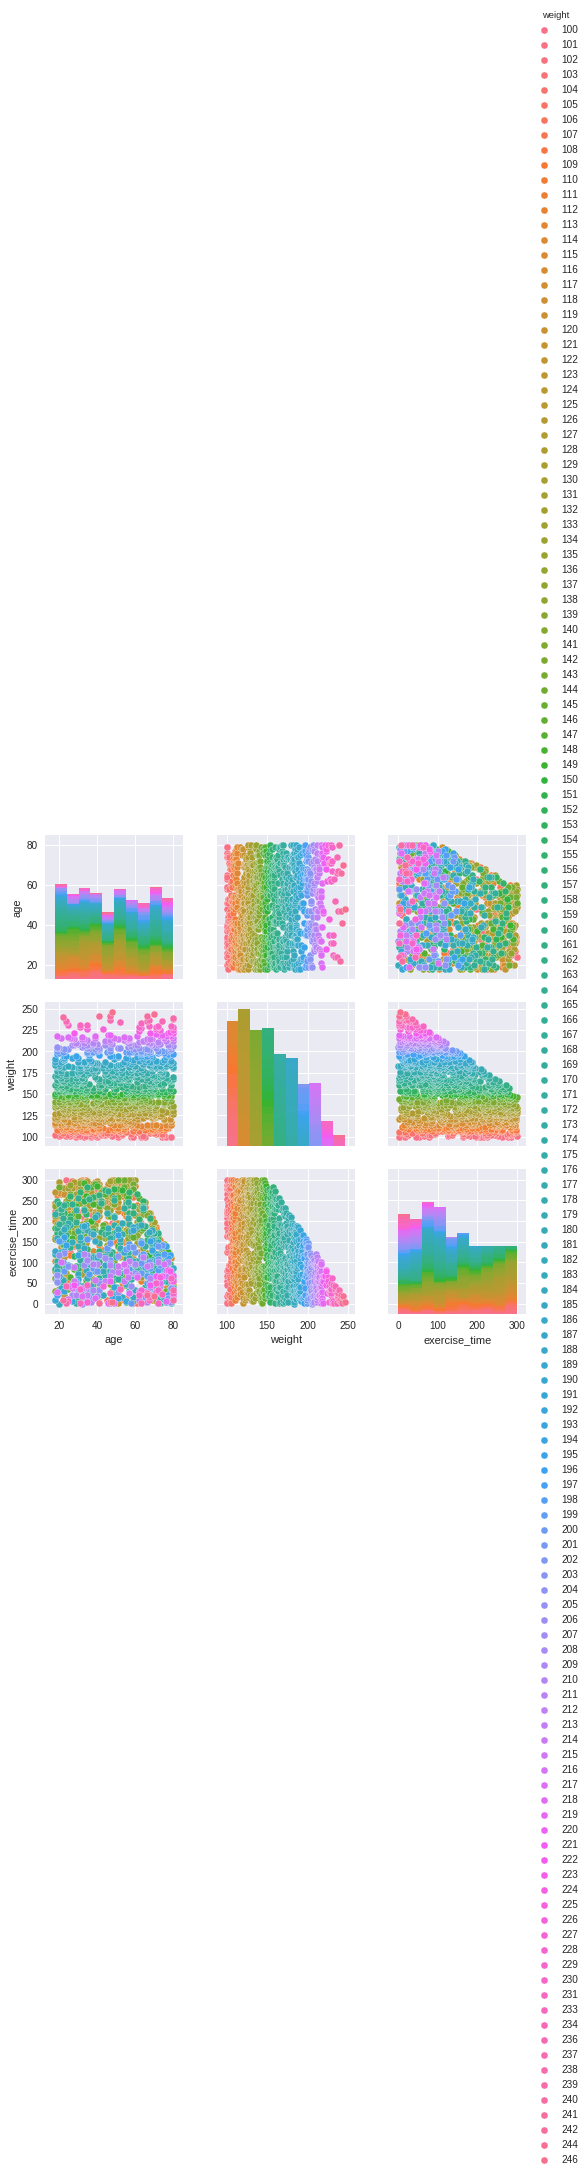

In [103]:
import seaborn as sns
sns.pairplot(df, hue='weight', size=2.5);

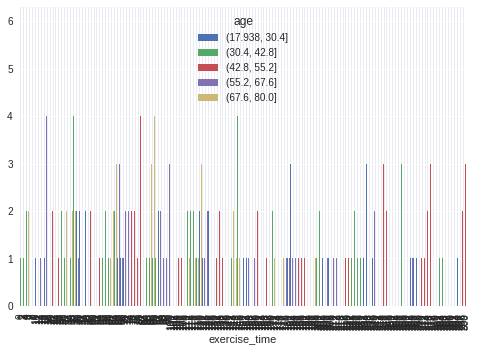

In [104]:
age_bins = pd.cut(df['age'], 5)  # 5 equal-sized bins
ct = pd.crosstab(df['exercise_time'], age_bins)
ct.plot.bar()

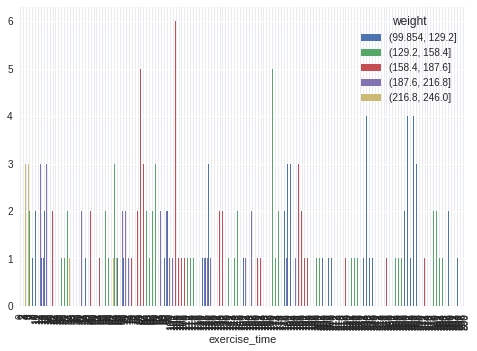

In [105]:
weight_bins = pd.cut(df['weight'], 5)  # 5 equal-sized bins
ct1 = pd.crosstab(df['exercise_time'], weight_bins)
ct1.plot.bar()

In [0]:
Looks like we found something, lets look at weight vs exercise time specifically.

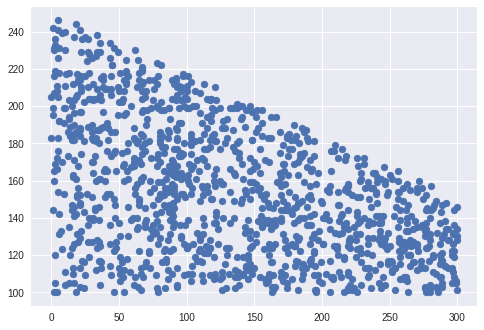

In [114]:
plt.scatter(df['exercise_time'], df['weight'])


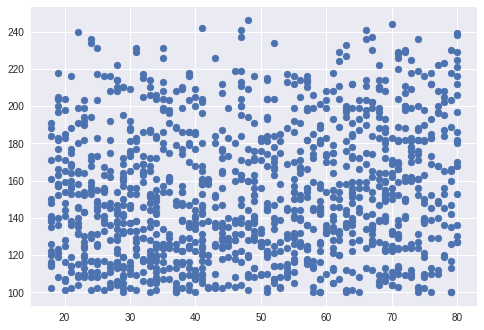

In [115]:
plt.scatter(df['age'], df['weight'])


Yep, there seems to be a relationship between exercise time and weight; however, the relationship between age and weight seems spurious. I was wrong!